In [1]:
!conda install -c conda-forge gdcm -y

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    gdcm-2.8.9                 |   py37h9a7466f_5         3.

In [2]:
pip install -U python-gdcm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 24.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import scipy.ndimage
import gdcm
import glob
from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.morphology import disk, opening, closing
from tqdm import tqdm
from IPython.display import HTML
from PIL import Image
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from os import listdir, mkdir

In [4]:
listdir("../input/")

['siim-covid19-detection',
 'rsna-str-pulmonary-embolism-detection',
 'osic-pulmonary-fibrosis-progression']

In [5]:
basepath = "../input/rsna-str-pulmonary-embolism-detection/"

In [6]:
train = pd.read_csv(basepath + "train.csv")
test = pd.read_csv(basepath + "test.csv")

In [7]:
train.shape

(1790594, 17)

In [8]:
train.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [9]:
if basepath == "../input/osic-pulmonary-fibrosis-progression/":
    train["dcm_path"] = basepath + "train/" + train.Patient + "/"
elif basepath == "../input/rsna-str-pulmonary-embolism-detection/":
    train["dcm_path"] = basepath + "train/" + train.StudyInstanceUID + "/" + train.SeriesInstanceUID 
else:
    train["dcm_path"] = basepath + "train/" + train.StudyInstanceUID + "/" 

In [10]:
def load_scans(dcm_path):
    if basepath == "../input/rsna-str-pulmonary-embolism-detection/":
        # We sort by ImagePositionPatient (z-coordinate) or by SliceLocation
        slices = [pydicom.dcmread(dcm_path + "/" + file) for file in listdir(dcm_path)]
        slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    else: #basepath == "../input/osic-pulmonary-fibrosis-progression/":    
        # This competition shows missing values in ImagePosition,
        # this is why we are sorting by filename number
        files = listdir(dcm_path)
        file_nums = [np.int(file.split(".")[0]) for file in files]
        sorted_file_nums = np.sort(file_nums)[::-1]
        slices = [pydicom.dcmread(dcm_path + "/" + str(file_num) + ".dcm" ) for file_num in sorted_file_nums]
    return slices

In [11]:
example = train.dcm_path.values[0]
scans = load_scans(example)

In [12]:
example

'../input/rsna-str-pulmonary-embolism-detection/train/6897fa9de148/2bfbb7fd2e8b'

In [13]:
scans[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 172
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10.474.405991.10080
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.38'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI DUAL', 'STD', 'SNRG', 'DET_AB']
(0008, 0016) SOP Class UID                       UI: 80e30f500244
(0008, 0018) SOP Instance UID                    UI: baedb900c69c
(0008, 0060) Modality                            CS: 'CT'
(0018, 0

In [14]:
HTML('<iframe width="600" height="400" src="https://www.youtube.com/embed/KZld-5W99cI" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')


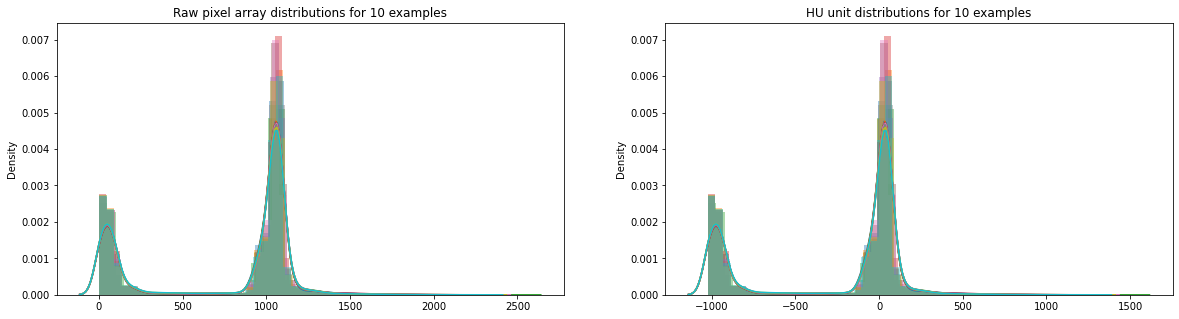

In [15]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
for n in range(10):
    image = scans[n].pixel_array.flatten()
    rescaled_image = image * scans[n].RescaleSlope + scans[n].RescaleIntercept
    sns.distplot(image.flatten(), ax=ax[0]);
    sns.distplot(rescaled_image.flatten(), ax=ax[1])
ax[0].set_title("Raw pixel array distributions for 10 examples")
ax[1].set_title("HU unit distributions for 10 examples");

In [16]:
def set_outside_scanner_to_air(raw_pixelarrays):
    # in OSIC we find outside-scanner-regions with raw-values of -2000. 
    # Let's threshold between air (0) and this default (-2000) using -1000
    raw_pixelarrays[raw_pixelarrays <= -1000] = 0
    return raw_pixelarrays

In [17]:
def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    images = set_outside_scanner_to_air(images)
    
    # convert to HU
    for n in range(len(slices)):
        
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)

In [18]:
hu_scans = transform_to_hu(scans)

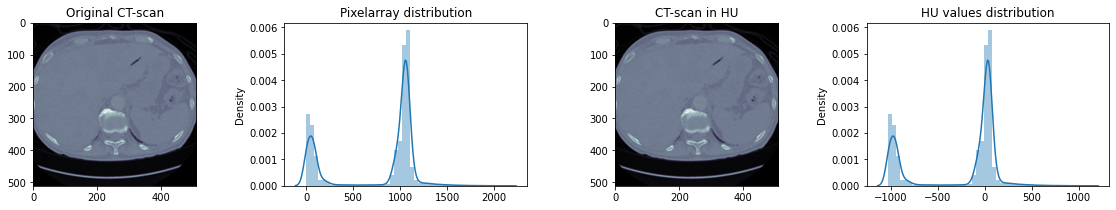

In [19]:
fig, ax = plt.subplots(1,4,figsize=(20,3))
ax[0].set_title("Original CT-scan")
ax[0].imshow(scans[0].pixel_array, cmap="bone")
ax[1].set_title("Pixelarray distribution");
sns.distplot(scans[0].pixel_array.flatten(), ax=ax[1]);

ax[2].set_title("CT-scan in HU")
ax[2].imshow(hu_scans[0], cmap="bone")
ax[3].set_title("HU values distribution");
sns.distplot(hu_scans[0].flatten(), ax=ax[3]);

for m in [0,2]:
    ax[m].grid(False)

In [20]:
N = 1000

In [21]:
def get_window_value(feature):
    if type(feature) == pydicom.multival.MultiValue:
        return np.int(feature[0])
    else:
        return np.int(feature)

pixelspacing_r = []
pixelspacing_c = []
slice_thicknesses = []
patient_id = []
patient_pth = []
row_values = []
column_values = []
window_widths = []
window_levels = []

if basepath == "../input/osic-pulmonary-fibrosis-progression/":
    patients = train.Patient.unique()[0:N]
else:
    patients = train.SeriesInstanceUID.unique()[0:N]

for patient in patients:
    patient_id.append(patient)
    if basepath == "../input/osic-pulmonary-fibrosis-progression/":
        path = train[train.Patient == patient].dcm_path.values[0]
    else:
        path = train[train.SeriesInstanceUID == patient].dcm_path.values[0]
    example_dcm = listdir(path)[0]
    patient_pth.append(path)
    dataset = pydicom.dcmread(path + "/" + example_dcm)
    
    window_widths.append(get_window_value(dataset.WindowWidth))
    window_levels.append(get_window_value(dataset.WindowCenter))
    
    spacing = dataset.PixelSpacing
    slice_thicknesses.append(dataset.SliceThickness)
    
    row_values.append(dataset.Rows)
    column_values.append(dataset.Columns)
    pixelspacing_r.append(spacing[0])
    pixelspacing_c.append(spacing[1])
    
scan_properties = pd.DataFrame(data=patient_id, columns=["patient"])
scan_properties.loc[:, "rows"] = row_values
scan_properties.loc[:, "columns"] = column_values
scan_properties.loc[:, "area"] = scan_properties["rows"] * scan_properties["columns"]
scan_properties.loc[:, "pixelspacing_r"] = pixelspacing_r
scan_properties.loc[:, "pixelspacing_c"] = pixelspacing_c
scan_properties.loc[:, "pixelspacing_area"] = scan_properties.pixelspacing_r * scan_properties.pixelspacing_c
scan_properties.loc[:, "slice_thickness"] = slice_thicknesses
scan_properties.loc[:, "patient_pth"] = patient_pth
scan_properties.loc[:, "window_width"] = window_widths
scan_properties.loc[:, "window_level"] = window_levels
scan_properties.head()

,patient,rows,columns,area,pixelspacing_r,pixelspacing_c,pixelspacing_area,slice_thickness,patient_pth,window_width,window_level
0,2bfbb7fd2e8b,512,512,262144,0.523438,0.523438,0.273987,2.0,../input/rsna-str-pulmonary-embolism-detection...,400,40
1,2805267980e7,512,512,262144,0.580078,0.580078,0.336491,2.0,../input/rsna-str-pulmonary-embolism-detection...,350,50
2,bac7becd2970,512,512,262144,0.615234,0.615234,0.378513,2.0,../input/rsna-str-pulmonary-embolism-detection...,400,40
3,7d17c72fd0ce,512,512,262144,0.648438,0.648438,0.420471,3.0,../input/rsna-str-pulmonary-embolism-detection...,400,40
4,275497911f02,512,512,262144,0.648438,0.648438,0.420471,3.0,../input/rsna-str-pulmonary-embolism-detection...,400,40


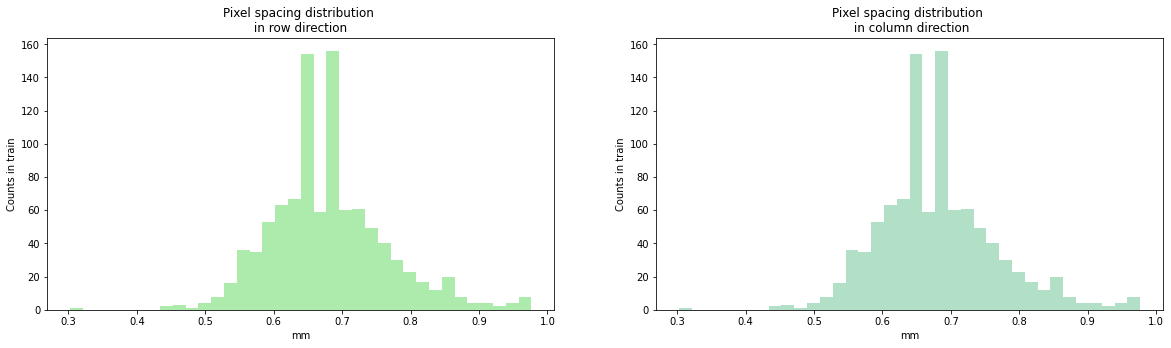

In [22]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(pixelspacing_r, ax=ax[0], color="Limegreen", kde=False)
ax[0].set_title("Pixel spacing distribution \n in row direction ")
ax[0].set_ylabel("Counts in train")
ax[0].set_xlabel("mm")
sns.distplot(pixelspacing_c, ax=ax[1], color="Mediumseagreen", kde=False)
ax[1].set_title("Pixel spacing distribution \n in column direction");
ax[1].set_ylabel("Counts in train");
ax[1].set_xlabel("mm");

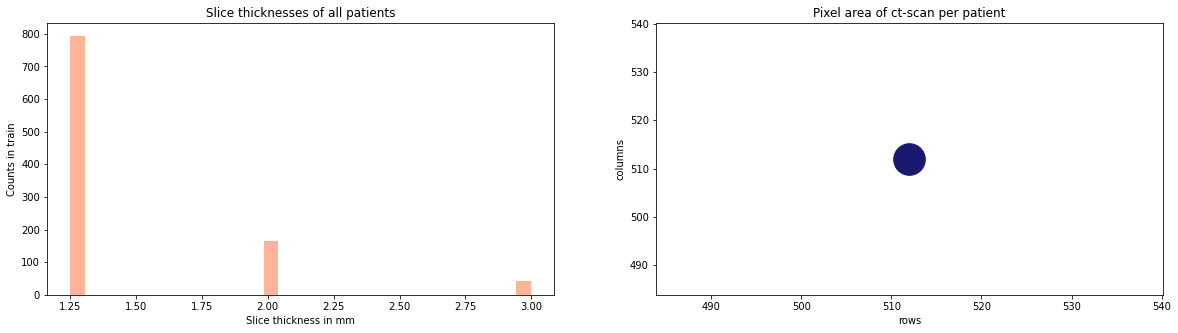

In [23]:
counts = scan_properties.groupby(["rows", "columns"]).size()
counts = counts.unstack()
counts.fillna(0, inplace=True)


fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(slice_thicknesses, color="orangered", kde=False, ax=ax[0])
ax[0].set_title("Slice thicknesses of all patients");
ax[0].set_xlabel("Slice thickness in mm")
ax[0].set_ylabel("Counts in train");

for n in counts.index.values:
    for m in counts.columns.values:
        ax[1].scatter(n, m, s=counts.loc[n,m], c="midnightblue")
ax[1].set_xlabel("rows")
ax[1].set_ylabel("columns")
ax[1].set_title("Pixel area of ct-scan per patient");

In [24]:
scan_properties["r_distance"] = scan_properties.pixelspacing_r * scan_properties.rows
scan_properties["c_distance"] = scan_properties.pixelspacing_c * scan_properties["columns"]
scan_properties["area_cm2"] = 0.1* scan_properties["r_distance"] * 0.1*scan_properties["c_distance"]
scan_properties["slice_volume_cm3"] = 0.1*scan_properties.slice_thickness * scan_properties.area_cm2

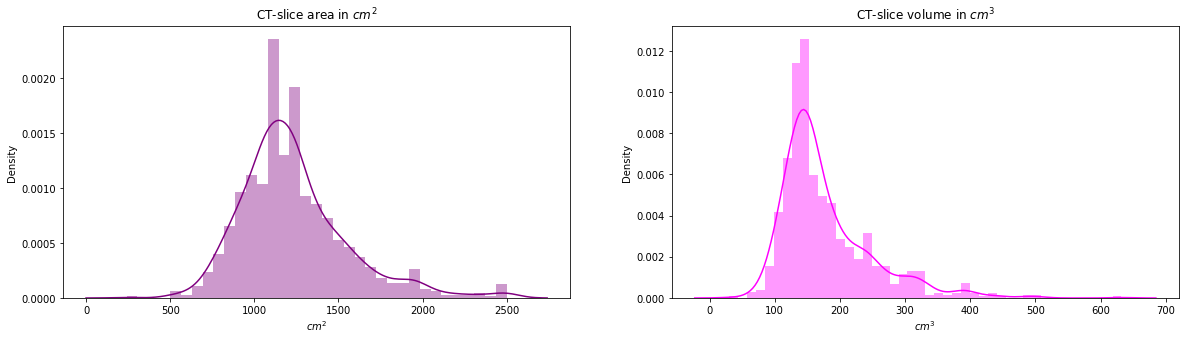

In [25]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(scan_properties.area_cm2, ax=ax[0], color="purple")
sns.distplot(scan_properties.slice_volume_cm3, ax=ax[1], color="magenta")
ax[0].set_title("CT-slice area in $cm^{2}$")
ax[1].set_title("CT-slice volume in $cm^{3}$")
ax[0].set_xlabel("$cm^{2}$")
ax[1].set_xlabel("$cm^{3}$");

In [26]:
max_path = scan_properties[
    scan_properties.area_cm2 == scan_properties.area_cm2.max()].patient_pth.values[0]
min_path = scan_properties[
    scan_properties.area_cm2 == scan_properties.area_cm2.min()].patient_pth.values[0]

min_scans = load_scans(min_path)
min_hu_scans = transform_to_hu(min_scans)

max_scans = load_scans(max_path)
max_hu_scans = transform_to_hu(max_scans)

background_water_hu_scans = max_hu_scans.copy()

In [27]:
def set_manual_window(hu_image, custom_center, custom_width):
    w_image = hu_image.copy()
    min_value = custom_center - (custom_width/2)
    max_value = custom_center + (custom_width/2)
    w_image[w_image < min_value] = min_value
    w_image[w_image > max_value] = max_value
    return w_image

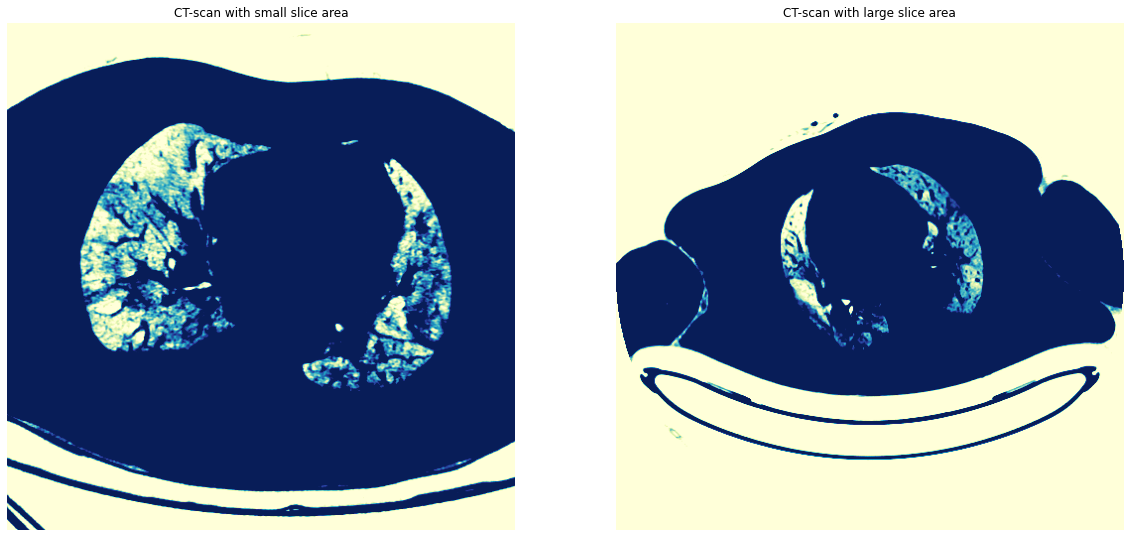

In [28]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(set_manual_window(min_hu_scans[np.int(len(min_hu_scans)/2)], -700, 255), cmap="YlGnBu")
ax[1].imshow(set_manual_window(max_hu_scans[np.int(len(max_hu_scans)/2)], -700, 255), cmap="YlGnBu");
ax[0].set_title("CT-scan with small slice area")
ax[1].set_title("CT-scan with large slice area");
for n in range(2):
    ax[n].axis("off")


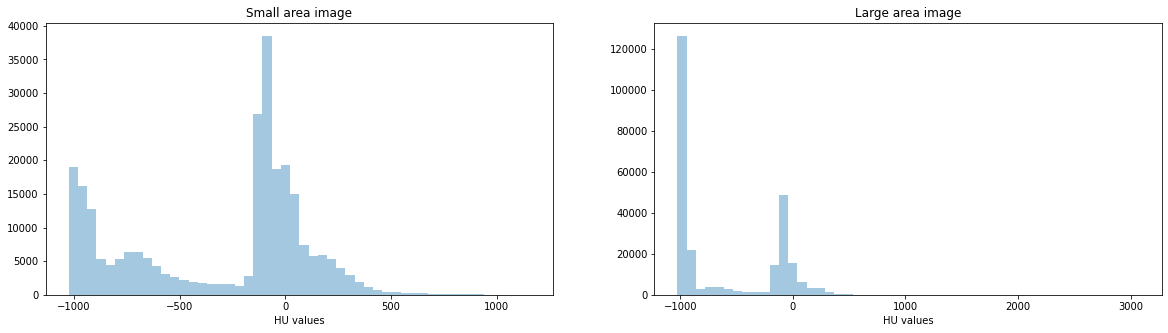

In [29]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(max_hu_scans[np.int(len(max_hu_scans)/2)].flatten(), kde=False, ax=ax[1])
ax[1].set_title("Large area image")
sns.distplot(min_hu_scans[np.int(len(min_hu_scans)/2)].flatten(), kde=False, ax=ax[0])
ax[0].set_title("Small area image")
ax[0].set_xlabel("HU values")
ax[1].set_xlabel("HU values");


In [30]:
max_path = scan_properties[
    scan_properties.slice_volume_cm3 == scan_properties.slice_volume_cm3.max()].patient_pth.values[0]
min_path = scan_properties[
    scan_properties.slice_volume_cm3 == scan_properties.slice_volume_cm3.min()].patient_pth.values[0]

min_scans = load_scans(min_path)
min_hu_scans = transform_to_hu(min_scans)

max_scans = load_scans(max_path)
max_hu_scans = transform_to_hu(max_scans)


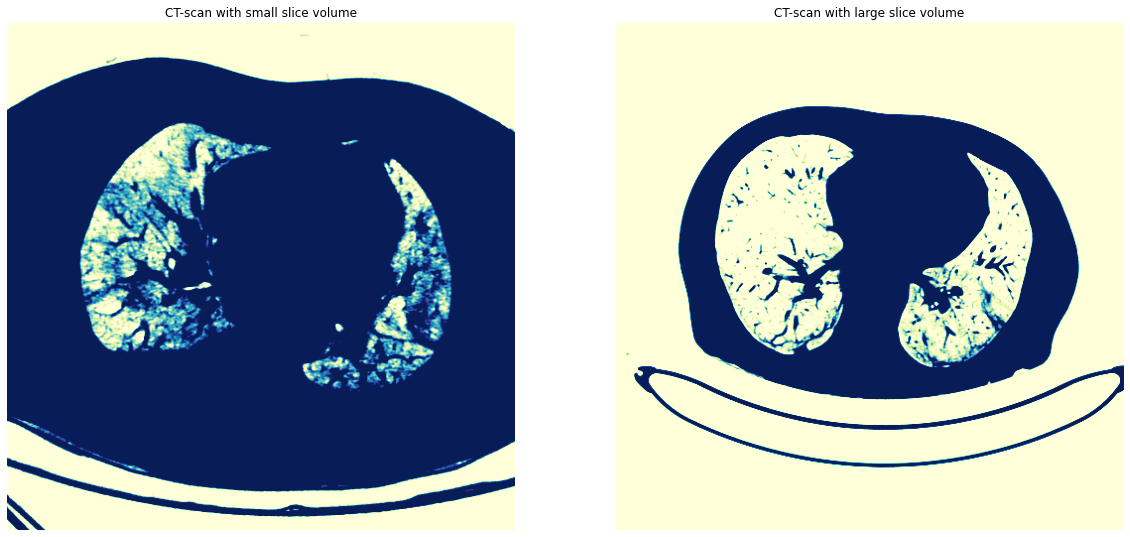

In [31]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(set_manual_window(min_hu_scans[np.int(len(min_hu_scans)/2)], -700, 255), cmap="YlGnBu")
ax[1].imshow(set_manual_window(max_hu_scans[np.int(len(max_hu_scans)/2)], -700, 255), cmap="YlGnBu");
ax[0].set_title("CT-scan with small slice volume")
ax[1].set_title("CT-scan with large slice volume");
for n in range(2):
    ax[n].axis("off")

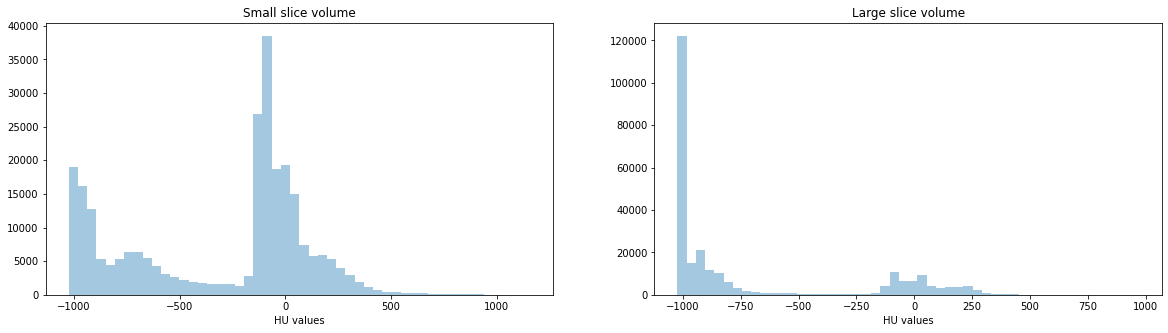

In [32]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(max_hu_scans[np.int(len(max_hu_scans)/2)].flatten(), kde=False, ax=ax[1])
ax[1].set_title("Large slice volume")
sns.distplot(min_hu_scans[np.int(len(min_hu_scans)/2)].flatten(), kde=False, ax=ax[0])
ax[0].set_title("Small slice volume")
ax[0].set_xlabel("HU values")
ax[1].set_xlabel("HU values");

In [33]:
def plot_3d(image, threshold=700, color="navy"):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces,_,_ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.2)
    mesh.set_facecolor(color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

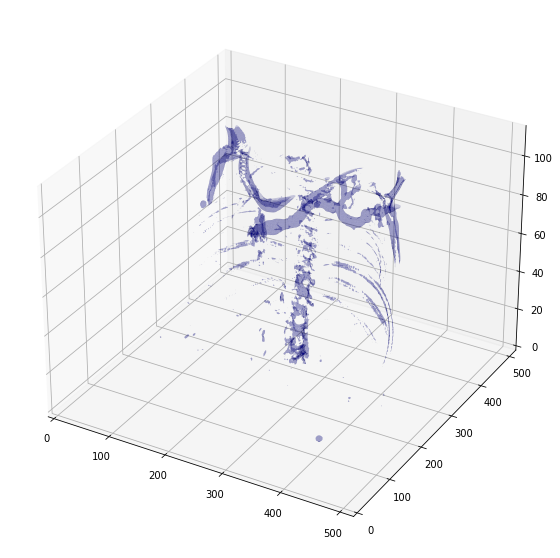

In [34]:
plot_3d(max_hu_scans)

In [35]:
old_distribution = max_hu_scans.flatten()

In [36]:
example = train.dcm_path.values[0]
scans = load_scans(example)
hu_scans = transform_to_hu(scans)

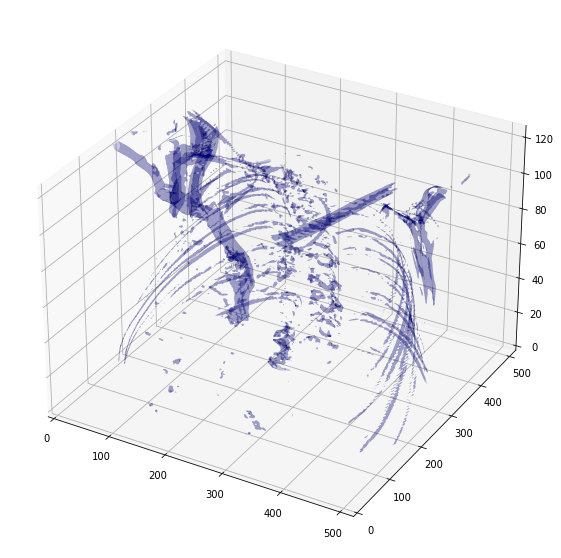

In [37]:
plot_3d(hu_scans)

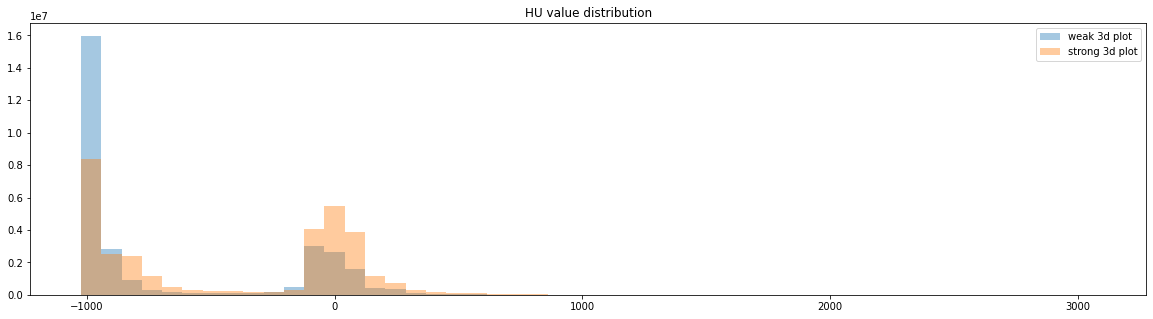

In [38]:
plt.figure(figsize=(20,5))
sns.distplot(old_distribution, label="weak 3d plot", kde=False)
sns.distplot(hu_scans.flatten(), label="strong 3d plot", kde=False)
plt.title("HU value distribution")
plt.legend();

In [39]:
print(len(max_hu_scans), len(hu_scans))

113 124


In [40]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)
    
    resize_factor = spacing / new_spacing
    new_shape = np.round(image.shape * resize_factor)
    
    # recompute the resize factor and spacing such that we match the rounded new shape above
    rounded_resize_factor = new_shape / image.shape
    rounded_new_spacing = spacing / rounded_resize_factor
    
    # zoom with resize factor
    image = scipy.ndimage.interpolation.zoom(image, rounded_resize_factor, mode='nearest')
    
    return image, rounded_new_spacing

In [41]:
img_resampled, spacing = resample(max_hu_scans, scans, [1,1,1])
print("Shape before resampling\t", max_hu_scans.shape)
print("Shape after resampling\t", img_resampled.shape)

Shape before resampling	 (113, 512, 512)
Shape after resampling	 (226, 268, 268)


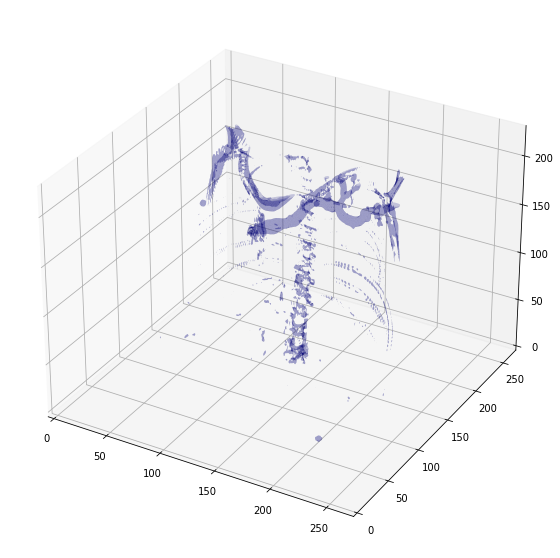

In [42]:
plot_3d(img_resampled)

In [43]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
    
def fill_lungs(binary_image):
    image = binary_image.copy()
    # For every slice we determine the largest solid structure
    for i, axial_slice in enumerate(image):
        axial_slice = axial_slice - 1
        labeling = measure.label(axial_slice)
        l_max = largest_label_volume(labeling, bg=0)

        if l_max is not None: #This slice contains some lung
            image[i][labeling != l_max] = 1
    return image

In [44]:
def segment_lung_mask(image):
    segmented = np.zeros(image.shape)   
    
    for n in range(image.shape[0]):
        binary_image = np.array(image[n] > -320, dtype=np.int8)+1
        labels = measure.label(binary_image)
        
        bad_labels = np.unique([labels[0,:], labels[-1,:], labels[:,0], labels[:,-1]])
        for bad_label in bad_labels:
            binary_image[labels == bad_label] = 2
    
        #We have a lot of remaining small signals outside of the lungs that need to be removed. 
        #In our competition closing is superior to fill_lungs 
        selem = disk(2)
        binary_image = opening(binary_image, selem)
    
        binary_image -= 1 #Make the image actual binary
        binary_image = 1-binary_image # Invert it, lungs are now 1
        
        segmented[n] = binary_image.copy() * image[n]
    
    return segmented

Text(0, 0.5, 'count')

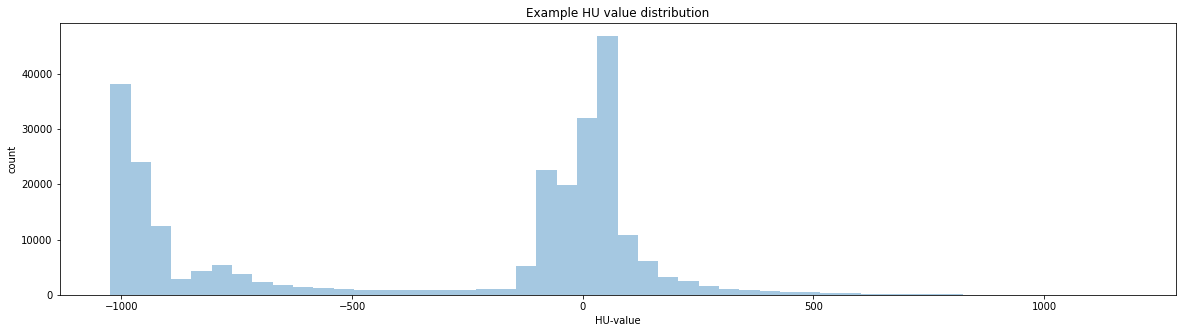

In [45]:
plt.figure(figsize=(20,5))
sns.distplot(hu_scans[20], kde=False)
plt.title("Example HU value distribution");
plt.xlabel("HU-value")
plt.ylabel("count")

In [46]:
binary_image = np.array((hu_scans[20]>-320), dtype=np.int8) + 1
np.unique(binary_image)

array([1, 2], dtype=int8)

In [47]:
labels = measure.label(binary_image)

bad_labels = np.unique([labels[0,:], labels[-1,:], labels[:,0], labels[:,-1]])

In [48]:
binary_image_2 = binary_image.copy()
for bad_label in bad_labels:
    binary_image_2[labels == bad_label] = 2

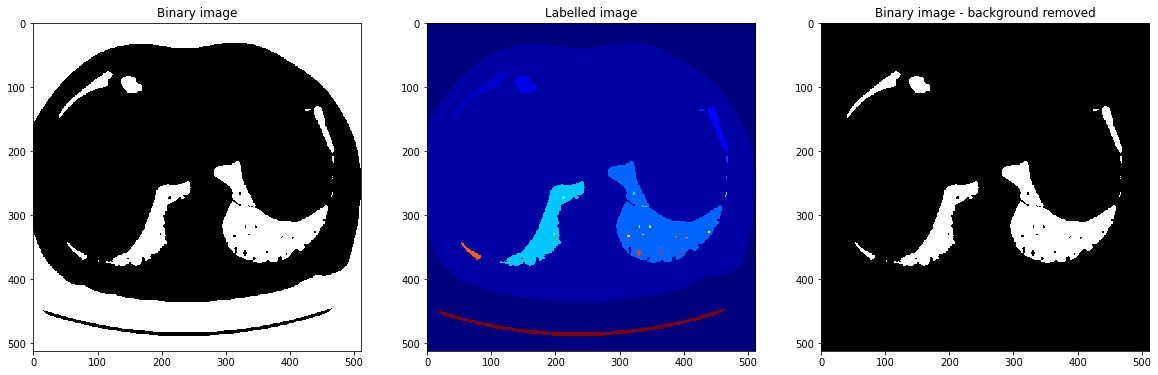

In [49]:
fig, ax = plt.subplots(1,3,figsize=(20,7))
ax[0].imshow(binary_image, cmap="binary", interpolation='nearest')
ax[1].imshow(labels, cmap="jet", interpolation='nearest')
ax[2].imshow(binary_image_2, cmap="binary", interpolation='nearest')

ax[0].set_title("Binary image")
ax[1].set_title("Labelled image");
ax[2].set_title("Binary image - background removed");

In [50]:
selem = disk(2)
closed_binary_2 = closing(binary_image_2, selem)

closed_binary_2 -= 1 #Make the image actual binary
closed_binary_2 = 1-closed_binary_2 # Invert it, lungs are now 1

In [51]:
filled_lungs_binary = fill_lungs(binary_image_2)

In [52]:
air_pocket_binary = closed_binary_2.copy()
# Remove other air pockets insided body
labels_2 = measure.label(air_pocket_binary, background=0)
l_max = largest_label_volume(labels_2, bg=0)
if l_max is not None: # There are air pockets
    air_pocket_binary[labels_2 != l_max] = 0

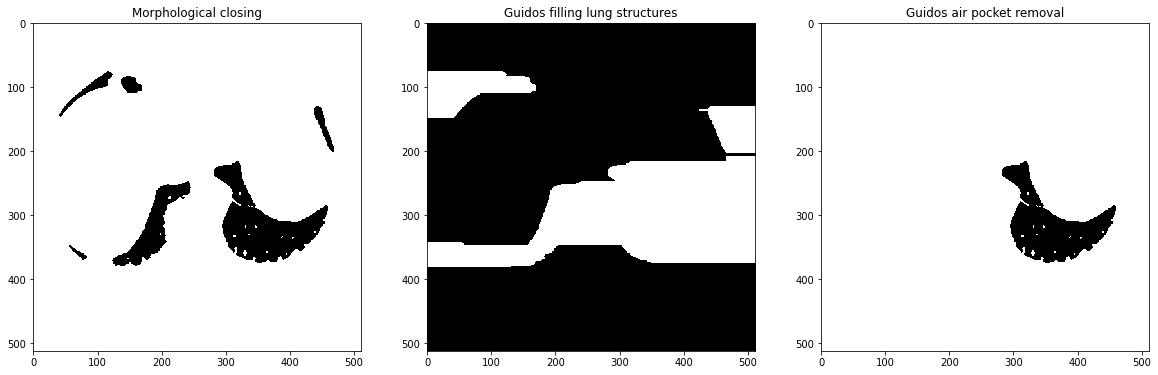

In [53]:
fig, ax = plt.subplots(1,3,figsize=(20,7))

ax[0].imshow(closed_binary_2, cmap="binary", interpolation='nearest')
ax[1].imshow(filled_lungs_binary, cmap="binary", interpolation='nearest')
ax[2].imshow(air_pocket_binary, cmap="binary", interpolation='nearest')


ax[0].set_title("Morphological closing");
ax[1].set_title("Guidos filling lung structures");
ax[2].set_title("Guidos air pocket removal");

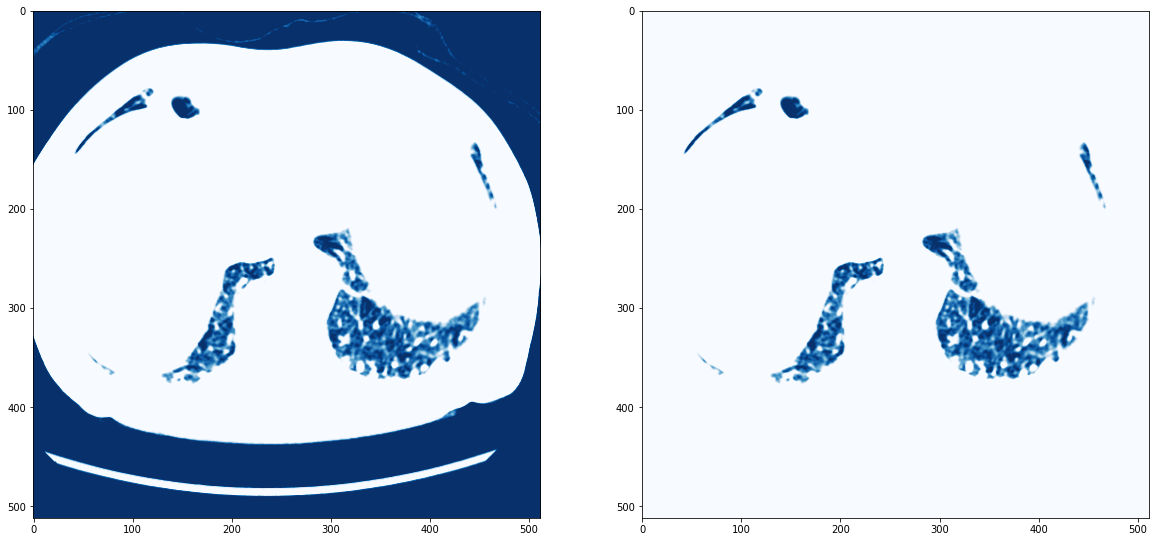

In [54]:
segmented = segment_lung_mask(np.array([hu_scans[20]]))

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(set_manual_window(hu_scans[20], -700, 255), cmap="Blues_r")
ax[1].imshow(set_manual_window(segmented[0], -700, 255), cmap="Blues_r");

In [55]:
segmented_lungs = segment_lung_mask(hu_scans)

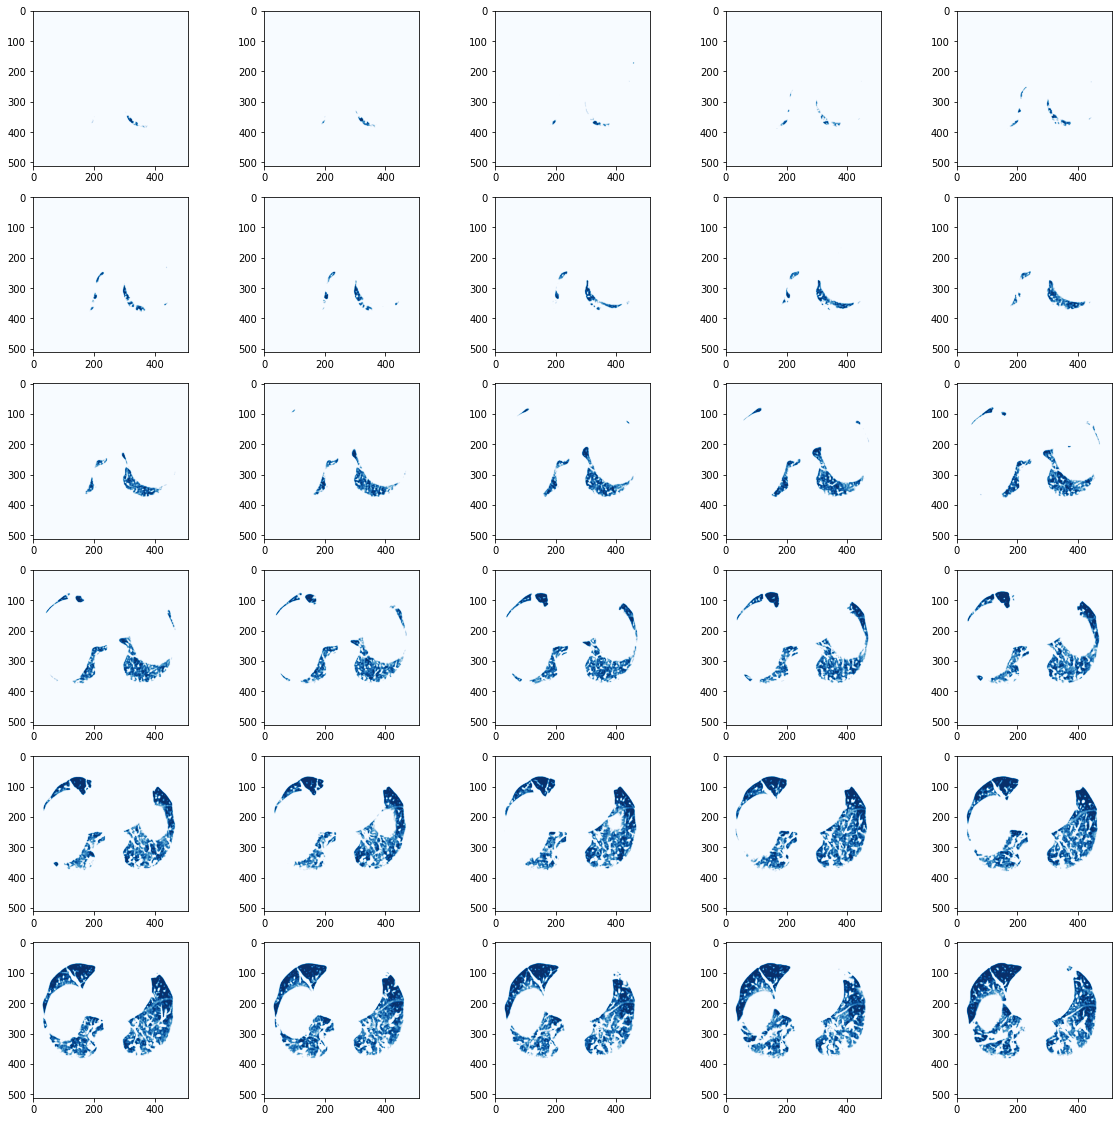

In [56]:
fig, ax = plt.subplots(6,5, figsize=(20,20))
for n in range(6):
    for m in range(5):
        ax[n,m].imshow(set_manual_window(segmented_lungs[(n+1)*5+m], -700, 255), cmap="Blues_r")

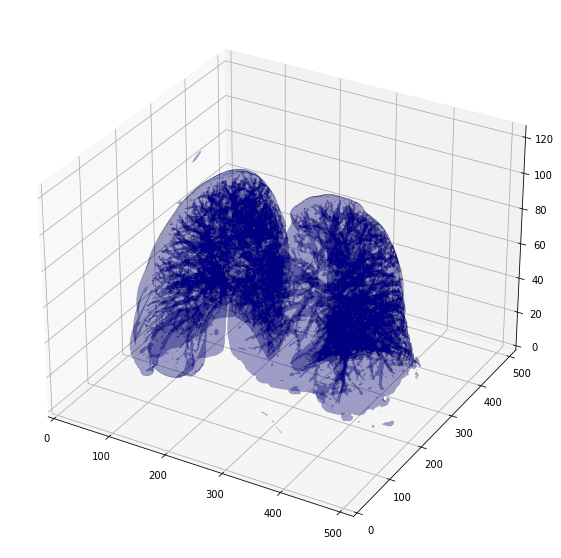

In [57]:
plot_3d(segmented_lungs, threshold=-600)


In [58]:
image_sizes = scan_properties.groupby(["rows", "columns"]).size().sort_values(ascending=False)
image_sizes

rows  columns
512   512        1000
dtype: int64

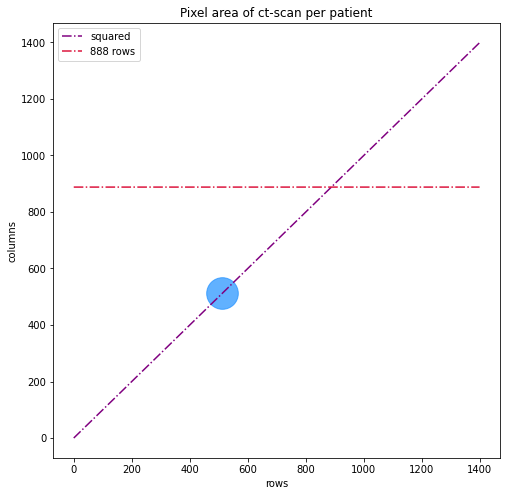

In [59]:
plt.figure(figsize=(8,8))
for n in counts.index.values:
    for m in counts.columns.values:
        plt.scatter(n, m, s=counts.loc[n,m], c="dodgerblue", alpha=0.7)
plt.xlabel("rows")
plt.ylabel("columns")
plt.title("Pixel area of ct-scan per patient");
plt.plot(np.arange(0,1400), '-.', c="purple", label="squared")
plt.plot(888 * np.ones(1400), '-.', c="crimson", label="888 rows");
plt.legend();

In [60]:
class ImageObserver:
    
    def __init__(self, scan_properties, batch_size):
        self.scan_properties = scan_properties
        self.batch_size = batch_size
    
    def select_group(self, group=(512,512)):
        self.group = group
        self.name = "rows {}, columns {}".format(group[0], group[1])
        self.batch_shape = (self.batch_size, group[0], group[1])
        self.selection = self.scan_properties[
            (self.scan_properties["rows"]==group[0]) & (self.scan_properties["columns"]==group[1])
        ].copy()
        self.patient_pths = self.selection.patient_pth.unique()
    
    
    def get_loader(self):
        
        idx=0
        images = np.zeros(self.batch_shape)
        
        for path in self.patient_pths:
            
            scans = load_scans(path)
            hu_scans = transform_to_hu(scans)
            images[idx,:,:] = hu_scans[0]
            
            idx += 1
            if idx == self.batch_shape[0]:
                yield images
                images = np.zeros(self.batch_shape)
                idx = 0
        if idx > 0:
            yield images

In [61]:
my_choice = image_sizes.index.values[0]
print(my_choice)
to_display = 4

(512, 512)


In [62]:
observer = ImageObserver(scan_properties, to_display)
observer.select_group(my_choice)
observer_iterator = observer.get_loader()

In [63]:
images = next(observer_iterator)

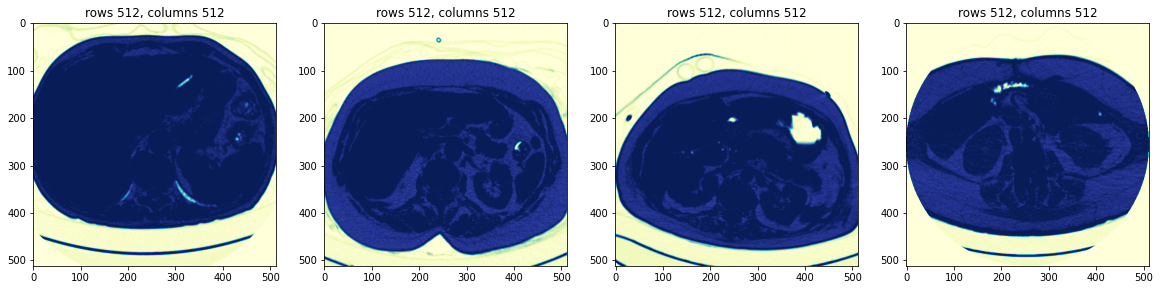

In [64]:
fig, ax = plt.subplots(1,to_display,figsize=(20,5))


for m in range(to_display):
    image = images[m]
    ax[m].imshow(set_manual_window(image, -500, 1000), cmap="YlGnBu")
    ax[m].set_title(observer.name)